# Learning Conductance: Gaussian Process Regression for Molecular Electronics

Exemplary python code to demonstrate the machine learning and data process techniques. The following examples are done for a single trajectory, as provided with this notebook. The full data set is provided via the NOMAD Repository and Archive, as described in the paper.

First, the necessary packages are loaded. `sklearn`, `dscribe`, `matplotlib`, `ase` and `numpy` are required.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from dscribe import descriptors
import ase as ase

# this is used (but can be removed from the code) to give
# some feedback about the timing of the code
from tqdm import tqdm

Now, we load the data (trajectories and conductance trace). *A Warning:* This script is not parallelized to make it more simple and clear. This leads to long calculation times when parsing the data and creating the feature vectors. Thus, the number of frames is set to only 50 here. You can uncomment the correspondig line in the part below, and grab a coffee.

In [2]:
# load lines of trajectory
with open('trajectory_01.xyz') as file:
    lines = file.readlines()
    
# parse lines
atoms       = []
natoms      = int(lines[0].strip('\n'))
print('number of atoms :', natoms, flush = True)

coordinates = []


# calculate number of snapshots in trajectory
# CAUTION! For testing purposes this should be set to a 
# lower number, as these calculations take time!
nframes     = int(len(lines)/(natoms+2))
nframes     = 100 # override for testing purposes

# get atom symbols. We only have to go through the first
# snapshot, as these do not change
for i in range(2, natoms+2):
    atoms.append(lines[i].split()[0])

# get coordinates
for i in tqdm(range(nframes)):
    coords_frame = []
    for j in range(2, natoms+2):
        #print(i, j, i*(natoms+2)+j,
        #      lines[i*(natoms+2)+j].strip('\n').split())
        # split line
        temp = lines[i*(natoms+2)+j].strip('\n').split()[1:4]
        coords_frame.append(np.array(temp, dtype = 'float'))

    coordinates.append(np.array(coords_frame))

coordinates = np.array(coordinates)

# load conductance and make it logarithmic
targets = np.log10(np.genfromtxt('transmission_01.dat'))

number of atoms : 534


100%|██████████| 100/100 [00:00<00:00, 956.08it/s]


Now, the coordinates from the trajectories have to be converted to a feature vector. Here, we will focus on the SOAP descriptor and a custom descriptor, which uses the size of the simulation box, the distance between the sulfur atoms and the distance from each sulfur atom to the closest gold atom. Information about the SOAP descriptor can be found in
[De et.al., Comparing molecules and solids across structural and alchemical space, Physical Chemistry Chemical Physics, Royal Society of Chemistry (RSC), 2016, 18, 13754-13769](https://pubs.rsc.org/en/content/articlelanding/2016/cp/c6cp00415f) and [Jäger et.al.,
Machine learning hydrogen adsorption on nanoclusters through structural descriptors 
npj Computational Materials, Springer Science and Business Media LLC, 2018, 4](https://www.nature.com/articles/s41524-018-0096-5). Information on the `dscribe` library can be found in [Himanen et.al.,
DScribe: Library of descriptors for machine learning in materials science 
Computer Physics Communications, Elsevier BV, 2020, 247, 106949](https://www.sciencedirect.com/science/article/pii/S0010465519303042?via%3Dihub).

Attention! Depending on the SOAP version, the `[0, :]` has to be removed in line 24 and 33.


In [3]:
# use soap descriptor
# these are the settings we studied, which are slow
soap = descriptors.SOAP(species = ['H', 'C', 'S', 'Au'],
                        periodic = False,
                        rcut = 14,
                        nmax = 8,
                        lmax = 4,
                        average = 'outer',
                        rbf = 'polynomial')

# exemplary settings for a faster creation of the feature vector
# rbf = 'polynomial' is especially expensive
soap = descriptors.SOAP(species = ['H', 'C', 'S', 'Au'],
                        periodic = False,
                        rcut = 10,
                        nmax = 4,
                        lmax = 4,
                        average = 'outer')

# as the following process can be too memory-demanding for
# smaller PCs, we prefere to use numpy, but first we have get the
# dimensions of the feature vector with the chosen settings
mol = ase.Atoms(np.array(atoms), coordinates[0])
size_soap = len(soap.create(mol, n_jobs = 1)[0, :])

# create empty numpy array
features_soap = np.zeros([nframes, size_soap])

# loop over coordinates and create feature vector for each
# ATTENTION: This is slow!
for i in tqdm(range(len(coordinates))):
    mol = ase.Atoms(np.array(atoms), coordinates[i])
    features_soap[i, :] = soap.create(mol, n_jobs = 1)[0, :]

100%|██████████| 100/100 [00:03<00:00, 25.72it/s]


In [4]:
print('Dimension of SOAP feature vector:', np.shape(features_soap))

Dimension of SOAP feature vector: (100, 680)


In [5]:
# use custom descriptor
# get indices of sulfur and gold atoms
ind_au = np.where(np.array(atoms) == 'Au')[0]
ind_s  = np.where(np.array(atoms) == 'S')[0]

features_custom = []
for coords in tqdm(coordinates):
    feature_vector = []

    # we use ase again for distance calculations
    mol = ase.Atoms(np.array(atoms), coords)
    
    # get size of simulation box by checking the smallest
    # and largest z coordinates
    feature_vector.append(np.max(coords[:, 2]) - np.min(coords[:, 2]))

    # get S-Au distances
    for s in ind_s:
        dist = mol.get_distances(s, ind_au, mic = True)
        feature_vector.append(min(dist))

    # get distance between sulfur atoms
    for i in range(len(ind_s)):
        for j in range(i, len(ind_s)):
            feature_vector.append(mol.get_distance(ind_s[i], ind_s[j], mic = True))


    
    # append single feature vector to features
    features_custom.append(feature_vector)
    
features_custom = np.array(features_custom)

100%|██████████| 100/100 [00:00<00:00, 166.33it/s]


In [6]:
print('Dimension of custom feature vector:', np.shape(features_custom))

Dimension of custom feature vector: (100, 120)


We are now ready to train a Gaussian Process and evaluate its performance. We perform a simple train-test-split here, but it should be noted that this is not appropriate to really estimate the performance of this approach. This, e.g., could be done by k-fold-CV, or repeated train-test-splits. We don't scale the features here, as this led to worse performance.

In [7]:
# perform splitting of the data sets
# this line is a bit long
features_soap_train, features_soap_test, features_custom_train, features_custom_test,targets_train, targets_test = train_test_split(features_soap, features_custom, targets[:nframes], train_size = 0.1)

# prepare two instances of GPR
gpr_soap = GaussianProcessRegressor(kernel = 1.0*Matern(1.0, nu = 1.5),
                                    n_restarts_optimizer = 40)

gpr_custom = GaussianProcessRegressor(kernel = 1.0*Matern(1.0, nu = 1.5),
                                      n_restarts_optimizer = 40)

# fit GPR for both features
gpr_soap.fit(features_soap_train, targets_train)
gpr_custom.fit(features_custom_train, targets_train)

# get predictions
predictions_soap = gpr_soap.predict(features_soap_test)
predictions_custom = gpr_custom.predict(features_custom_test)

To analyze the results, we plot scatter plots and print the mean absolute error and R².

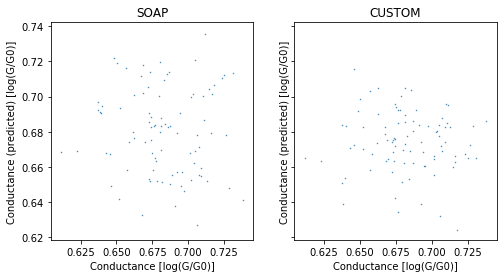

MAE (SOAP): 0.029355245051571333
MAE (custom): 0.026484950830463427
R2 (SOAP): -1.247460926634015
R2 (custom): -2.707148596905418


In [8]:
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (8,4))
axes[0].set_title('SOAP')
axes[0].set_xlabel('Conductance [log(G/G0)]')
axes[0].set_ylabel('Conductance (predicted) [log(G/G0)]')
axes[0].scatter(targets_test, predictions_soap, s = 0.2)

axes[1].set_title('CUSTOM')
axes[1].set_xlabel('Conductance [log(G/G0)]')
axes[1].set_ylabel('Conductance (predicted) [log(G/G0)]')
axes[1].scatter(targets_test, predictions_custom, s = 0.2)
plt.show()

print('MAE (SOAP):', mean_absolute_error(predictions_soap, targets_test))
print('MAE (custom):', mean_absolute_error(predictions_custom, targets_test))
print('R2 (SOAP):', r2_score(predictions_soap, targets_test))
print('R2 (custom):', r2_score(predictions_custom, targets_test))

We can also plot the histogram of the calculated and predicted conductance, but note that this is of limited use to systematically study the performance of different approaches.

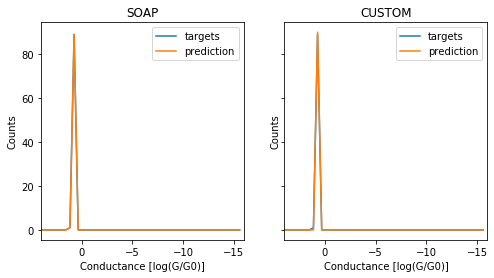

In [9]:
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (8,4))
bins = np.linspace(-16, 4, 50)

axes[0].set_title('SOAP')
axes[0].plot(bins[1:], np.histogram(targets_test, bins = bins)[0], label = 'targets')
axes[0].plot(bins[1:], np.histogram(predictions_soap, bins = bins)[0], label = 'prediction')

axes[1].set_title('CUSTOM')
axes[1].plot(bins[1:], np.histogram(targets_test, bins = bins)[0], label = 'targets')
axes[1].plot(bins[1:], np.histogram(predictions_custom, bins = bins)[0], label = 'prediction')

axes[0].set_xlim([4, -16])
axes[1].set_xlim([4, -16])

axes[0].set_xlabel('Conductance [log(G/G0)]')
axes[1].set_xlabel('Conductance [log(G/G0)]')
axes[0].set_ylabel('Counts')
axes[1].set_ylabel('Counts')
axes[0].legend()
axes[1].legend()

plt.show()